# NeuroTycho Visual Grating

In [61]:
import sys
sys.path.append('/Users/SP/code/spectralCV')

In [62]:
%matplotlib inline

# imports
from scv_funcs import access_nt as asc
import numpy as np
import scipy as sp
import scipy.io as io
import scipy.signal as sig
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import os

import neurodsp as ndsp
# from fooof import FOOOFGroup
from scv_funcs import lfpca

### Accessing data and creating lfpca objects

In [132]:
# getting data
# data_path = "/Users/Lauren/Data/NeuroTycho/VisualGrating/20100723S1_VGT_K2_KazuhitoTakenaka-ToruYanagawa_mat_ECoG128-Event3/"
data_path = "/Users/SP/Documents/02-Data/Neurotycho/VisualGrating/20100723S1_VGT_K2_KazuhitoTakenaka-ToruYanagawa_mat_ECoG128-Event3/"
# setting event data into pandas dataframe
matfile = io.loadmat(data_path + 'Event.mat', squeeze_me=True)
EventData = matfile['EventData']
EventIndex = matfile['EventIndex']

df_ecodes = pd.DataFrame(data = [EventData, EventIndex]).T
df_ecodes = df_ecodes.rename(columns={0: 'ecode', 1: 'EventIndex'})

In [136]:
# different stimulations 1 to 8 according to the boundary edges
edges = [(650,750), (950,1050), (1300,1400), (1600,1700), (1950,2050), (2250,2350), (2600,2700), (2900,3000)]
stims_ecode = np.empty((9,),dtype=object)
# blanks
stims_ecode[0] = df_ecodes[(df_ecodes['ecode'] > 300) & (df_ecodes['ecode'] < 400)]

for i,edge in enumerate(edges):
    lower = edge[0]
    upper = edge[1]
    stims_ecode[i+1]= df_ecodes[(df_ecodes['ecode'] > lower) & (df_ecodes['ecode'] < upper)]

# getting data from all channels
session = 0
chan = np.arange(1,129).tolist()
data = asc.get_ECoG(data_path, session, chan)

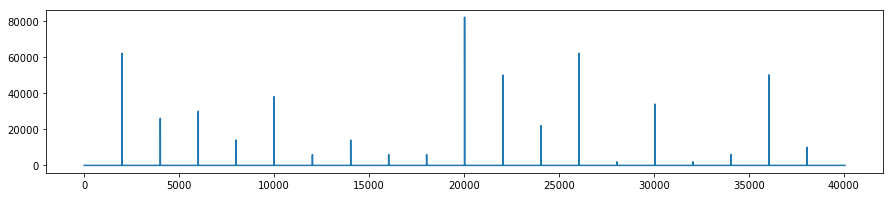

In [129]:
plt.figure(figsize=(15,3))
plt.plot(np.diff(np.array(stims[1]['EventIndex'])))

In [142]:
import pdb

In [143]:
# getting the data from each stim lookup table in event data code
def get_stimdata(stim_ecode):
    stimdata = None
    stimdata = np.vstack((data[0][stim_ecode['EventIndex']], data[1][stim_ecode['EventIndex']]))
    for c in range(2,128):
        stimdata = np.vstack((stimdata, data[c][stim_ecode['EventIndex']]))
    return stimdata

In [153]:
make_lfpca(stims_ecode[1], fs)

In [152]:
# because the length is different, making sure each window is 2000
def make_lfpca(stim_ecode, fs):
    
    # locations of where the differences occur
    diff_inds = list(np.where(np.diff(np.array(stim_ecode['EventIndex'])!=1)))[0] + 1
    
    #initialize
    start_ind = None
    end_ind = None
    
    stimdata = get_stimdata(stim_ecode)
    
    for idx, new_start_ind in enumerate(diff_inds):
        if new_start_ind == diff_inds[0]:
            start_ind = 0
            end_ind = new_start_ind
            print('a')
        elif new_start_ind == diff_inds[-1]:
            start_ind = new_start_ind
            end_ind = len(stim_ecode['ecode'])
            print('a')
        else:
            start_ind = diff_inds[idx-1]
            end_ind = new_start_ind
            print('a')
            
        print('a')
        inds = stim_ecode[start_ind:end_ind]
        win = sp.signal.windows.hamming(len(inds)) # applies a hamming window
        pdb.set_trace()
        for chan in range(128):
            chan_data = stimdata[chan][start_ind:end_ind]
            chan_data = chan_data*win
            P = np.abs(np.fft.fft(chan_data, n=int(fs), axis=1))**2.
            f_axis = np.fft.fftfreq(int(fs), 1/fs)
            pdb.set_trace()
            # initialize object with fourier data
            analysis_param = {'nperseg': 1000,
                              'noverlap': 0,
                              'spg_outlierpct': 2.,
                              'max_freq':200}

            vg_lfpca = lfpca.LFPCA(analysis_param)
            vg_lfpca.populate_fourier_data(P[:4,:,:], fs, f_axis[:300])


        
        
        x_sel = inds*win[:, np.newaxis]

        # precompute per-trial PSD, use n=fs for FFT to get 1Hz spacing
        P = np.abs(np.fft.fft(x_sel, n=int(fs), axis=1))**2.
        f_axis = np.fft.fftfreq(int(fs), 1/fs)

        # initialize object with fourier data
        analysis_param = {'nperseg': 1000,
                          'noverlap': 0,
                          'spg_outlierpct': 2.,
                          'max_freq':200}

        vg_lfpca = lfpca.LFPCA(analysis_param)
        vg_lfpca.populate_fourier_data(P[:4,:,:], fs, f_axis[:300])
        
        return vg_lfpca
#     kh_lfpca = lfpca.LFPCA(analysis_params=analysis_params)
#     kh_lfpca.populate_fourier_data(P[:4,:,:], fs, f_axis[:300])

In [140]:
stimdata_all[0][0].shape

(40072,)

In [ ]:
# example of using LFPCA

analysis_param = {'nperseg': 1000,
                  'noverlap': 0,
                  'spg_outlierpct': 2.,
                  'max_freq':200}

vg_lfpca = lfpca.LFPCA(analysis_param)
vg_lfpca.populate_ts_data(ITIdata, fs)
vg_lfpca_objs[8] = vg_lfpca

In [116]:
stimdata_all = np.empty(8, object)
# different stim data
def get_stimdata(data, num):
    stimdata = None
    stimdata = np.vstack((data[0][stims[num]['EventIndex']], data[1][stims[num]['EventIndex']]))
    for c in range(2,128):
        stimdata = np.vstack((stimdata, data[c][stims[num]['EventIndex']]))
    return stimdata

session_labels = np.arange(0,8).tolist()

for i in session_labels:
    stimdata = get_stimdata(data, i)
    stimdata_all[i] = stimdata
#     # initialize object with data and parameters
#     vg_lfpca = lfpca.LFPCA(analysis_param)
#     print(i)
#     vg_lfpca.populate_ts_data(stimdata, fs)
#     # compute all spectral attributes
#     vg_lfpca.compute_all_spectral()
#     vg_lfpca_objs[i] = vg_lfpca

In [12]:
saveout_path = "../results/nt_vg/"
lfpca_files = sorted([f for f in os.listdir(saveout_path) if 'lfpca_' in f])

### Visualizing the data from the saved

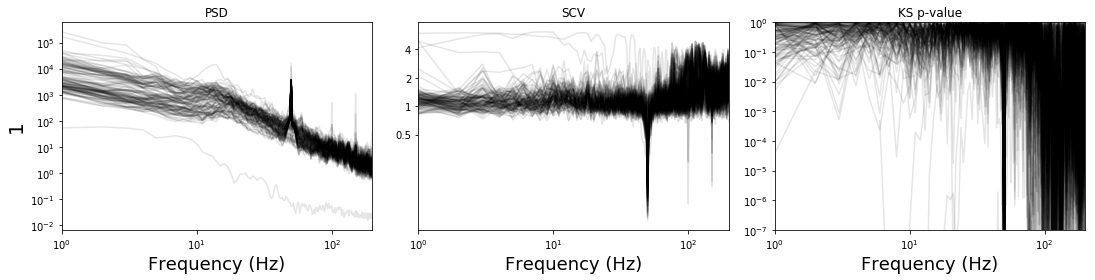

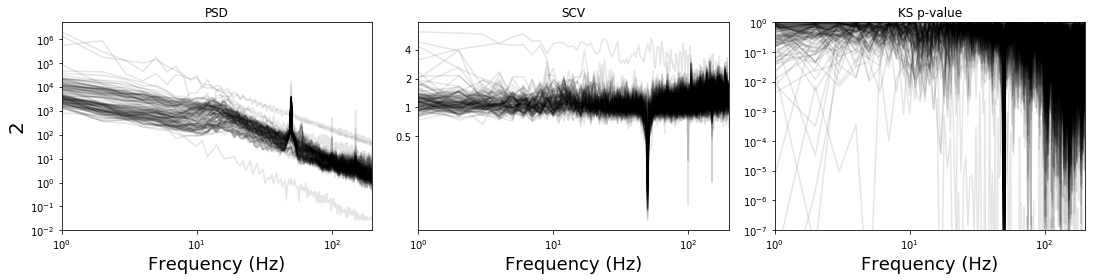

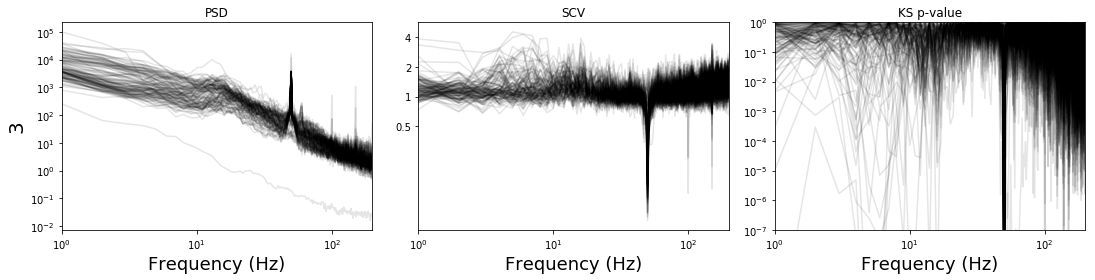

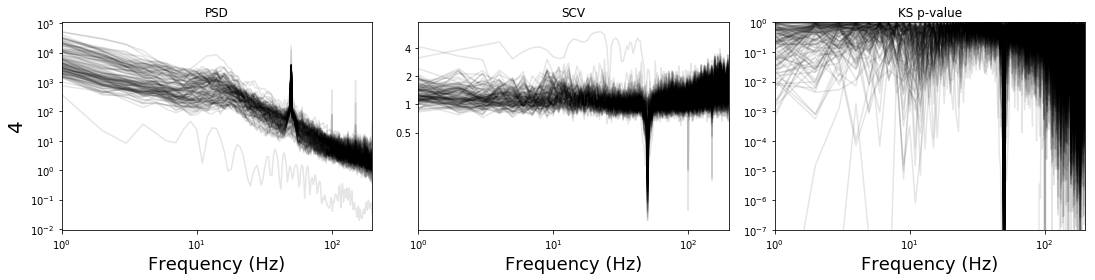

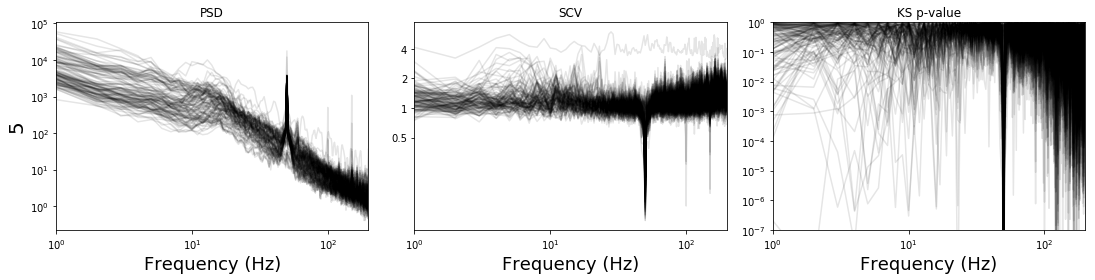

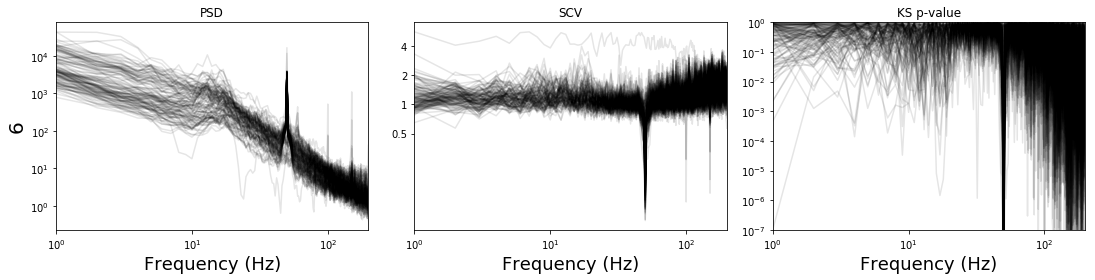

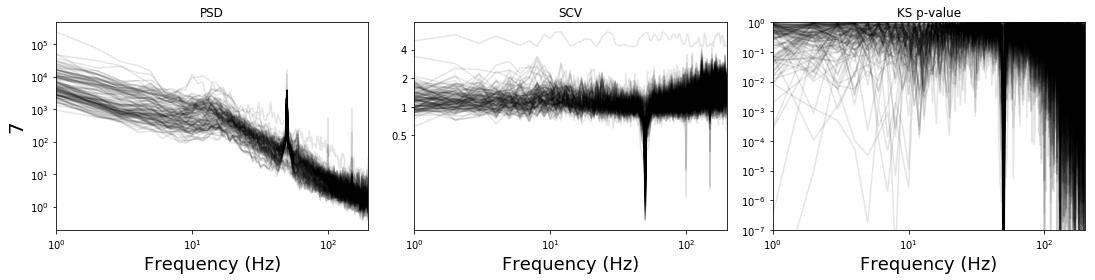

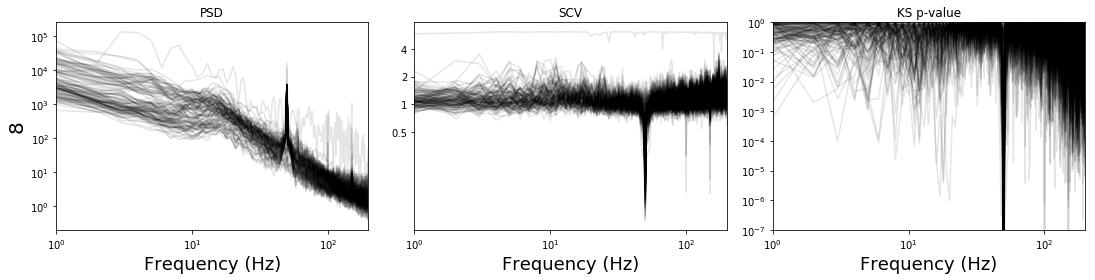

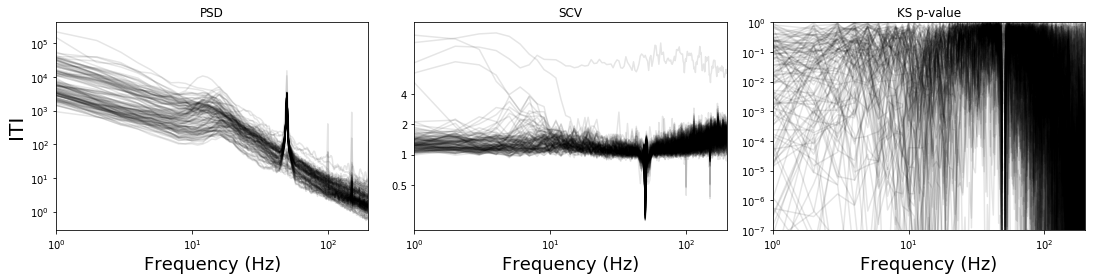

In [14]:
# visualize by separated conditions
lfpca_all = []
for f in range(len(lfpca_files)):
    nt_lfpca = lfpca.lfpca_load_spec(saveout_path+lfpca_files[f])
    lfpca_all.append(nt_lfpca)
    plt.figure(figsize=(15,4))
    nt_lfpca.plot_spectral(plot_mean=False)
    plt.subplot(1,3,1)
    plt.ylabel(lfpca_files[f][9:-4], fontsize=20)

#### Data Information
**Visual Grating Task**
> Monkey was sitting with head fixed. His arm motion was also restrained. 
ECoG data and eye position were recorded. There was a monitor in front of the monkey. 
Grating pattern that moves in eight direction was presented on the screen. 
There was no fixation required. Blank and stimulus pattern were switched alternatively every 2 sec. 
Stimulus events can be decoded from 129th channel by analog value. 
ECoG data were sampled at 1KHz.

* Data Format

    A. ECoG_chN.mat
        ECoGData_chN: ECoG signal (μV) recorded from electrodeN (1‐128), sampled at 1kHZ.
        The Location of electrode is documented in "K2.png".

    B. ECoG_time.mat
        ECoGTime: ECoGTime is a one row-vector contains Time-stamps with the same length as ECoGData_chN.

    C. Event.mat
        EventData: EventData is a one row-vector contains analog input.
        -Analog input format
      Ain indicates event time.
      [   0- 100] : preparation time before experiment
      [ 300- 400] : ITI
      [ 650- 750] : Stimulus 1 ( 45 degree)
      [ 950-1050] : Stimulus 2 ( 90 degree)
      [1300-1400] : Stimulus 3 (135 degree)
      [1600-1700] : Stimulus 4 (180 degree)
      [1950-2050] : Stimulus 5 (225 degree)
      [2250-2350] : Stimulus 6 (270 degree)
      [2600-2700] : Stimulus 7 (315 degree)
      [2900-3000] : Stimulus 8 (360 degree)

    EventTime: EventTime is a one row-vector contains corresponding time-stamp.